# Mid Lane Exploratory Data Analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

## Data Loading

In [2]:
data = pd.read_csv('../data/processed/mid.csv')
data.head()

op_score  win  length  kill  death  assist    kda    dmg  turret_dmg  \
0     3.671    0  27.117     2      1       2   4.00  17686        1450   
1     6.329    1  27.117     7      1       3  10.00  14916        3659   
2     5.536    1  25.600     4      4      16   5.00  21023        8655   
3     5.588    0  25.600    10      5       9   3.80  32608        2580   
4     7.871    1  28.233    11      4       8   4.75  40362       14413   

   magic_dmg  ...  dmg_per_gold  vision  pinks_bought  ward_kill  ward_place  \
0      11335  ...         1.879      19             5          1          13   
1      10292  ...         1.247      19             0          4           8   
2       8610  ...         1.678      14             0          1           7   
3       4389  ...         2.578      24             1          1          10   
4      38800  ...         2.601      23             3          4           7   

   cs_diff  gold_diff  level_diff  dmg_taken_diff  dmg_diff  
0       -7      -2547          -1          -16970      2770  
1        7       2547           1           16970     -2770  
2       10       -121           1           13516    -11585  
3      -10        121          -1          -13516     11585  
4       79       4344           3           -1189     18715  

[5 rows x 39 columns]

## Statistical Summary

In [3]:
# Printing descriptive statistics for each feature
print("Descriptive Statistics:\n")
print(data.describe())

Descriptive Statistics:

           op_score           win        length          kill         death  \
count  40878.000000  40878.000000  40878.000000  40878.000000  40878.000000   
mean       5.229302      0.500000     26.166271      5.932164      5.011180   
std        2.098976      0.500006      6.273887      4.116413      2.878639   
min        0.000000      0.000000     15.050000      0.000000      0.000000   
25%        3.789000      0.000000     22.200000      3.000000      3.000000   
50%        5.033000      0.500000     26.183000      5.000000      5.000000   
75%        6.575000      1.000000     30.250000      8.000000      7.000000   
max       10.000000      1.000000     59.600000     35.000000     20.000000   

             assist           kda           dmg    turret_dmg     magic_dmg  \
count  40878.000000  40878.000000  40878.000000  40878.000000  40878.000000   
mean       6.395078      3.667856  21091.829639   3635.234723  13788.006996   
std        4.449353      3

## Potential Outliers

In [4]:
features_to_plot = data.columns

# Identifying potential extreme outliers for each feature
print("\nPotential Extreme Outliers:\n")
for feature in features_to_plot:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    # Using a multiplier of 3 for extreme outliers
    outlier_count = data[(data[feature] < (Q1 - 3 * IQR)) | (data[feature] > (Q3 + 3 * IQR))][feature].count()
    print(f"{feature}: {outlier_count} potential extreme outliers")


Potential Extreme Outliers:

op_score: 0 potential extreme outliers
win: 0 potential extreme outliers
length: 4 potential extreme outliers
kill: 62 potential extreme outliers
death: 1 potential extreme outliers
assist: 9 potential extreme outliers
kda: 1148 potential extreme outliers
dmg: 46 potential extreme outliers
turret_dmg: 146 potential extreme outliers
magic_dmg: 7 potential extreme outliers
ad_dmg: 451 potential extreme outliers
all_dmg: 78 potential extreme outliers
dmg_taken: 68 potential extreme outliers
ad_dmg_taken: 61 potential extreme outliers
mitigated_dmg: 527 potential extreme outliers
total_heal: 885 potential extreme outliers
cs: 7 potential extreme outliers
gold: 2 potential extreme outliers
level: 0 potential extreme outliers
kp: 0 potential extreme outliers
dmg_perc: 0 potential extreme outliers
dmg_taken_perc: 26 potential extreme outliers
gold_perc: 3 potential extreme outliers
turret_kill: 7 potential extreme outliers
inhib_kill: 5535 potential extreme outli

## Correlation Heatmap

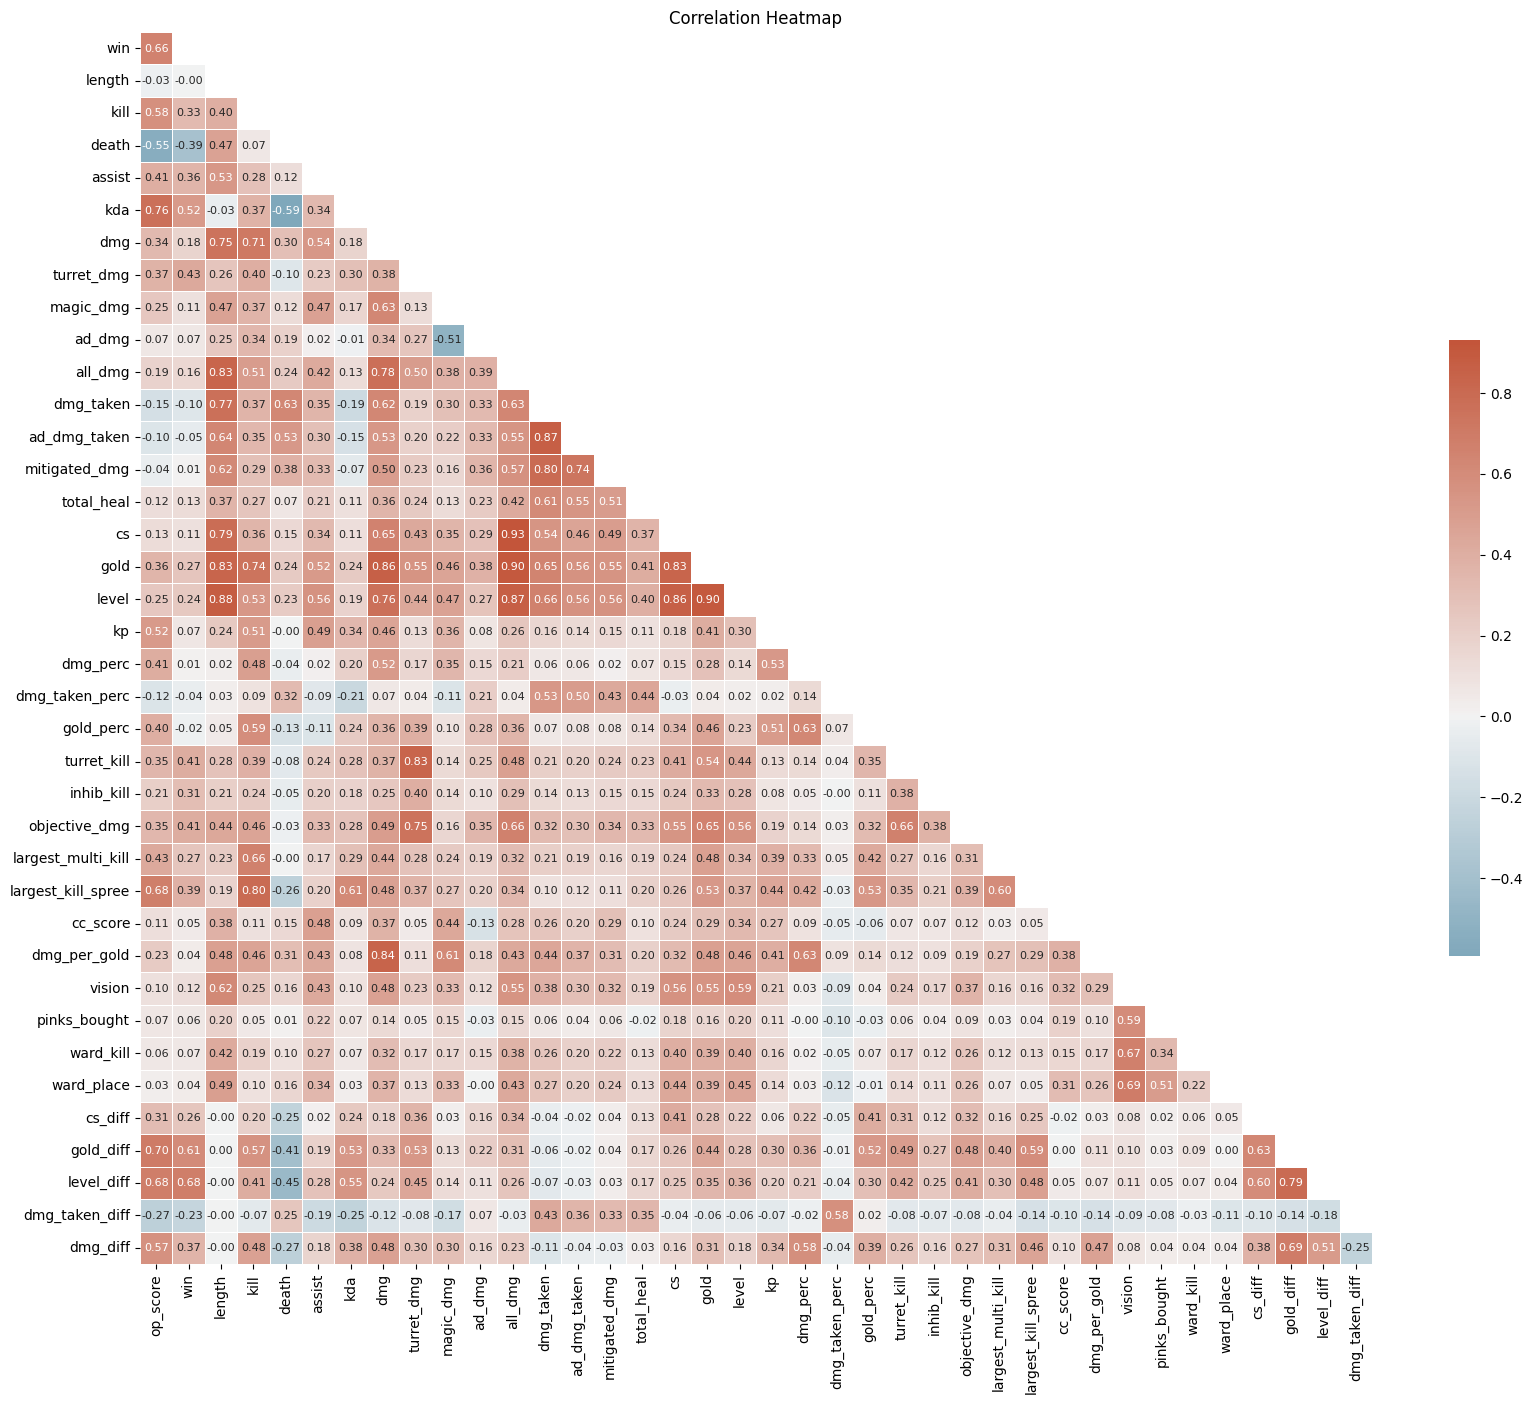

In [5]:
def plot_correlation_heatmap(data, title):
    # Calculate correlation matrix
    corr = data.corr()
    
    # Increase figure size
    plt.figure(figsize=(20, 16))
    
    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Adjust mask and df to ensure symmetry
    mask = mask[1:, :-1]
    corr = corr.iloc[1:,:-1]
    
    # Set up a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    # Draw the heatmap
    sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap=cmap, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"size": 8})
    
    plt.title(title)
    plt.show()

# Plotting the heatmap
plot_correlation_heatmap(data, 'Correlation Heatmap')

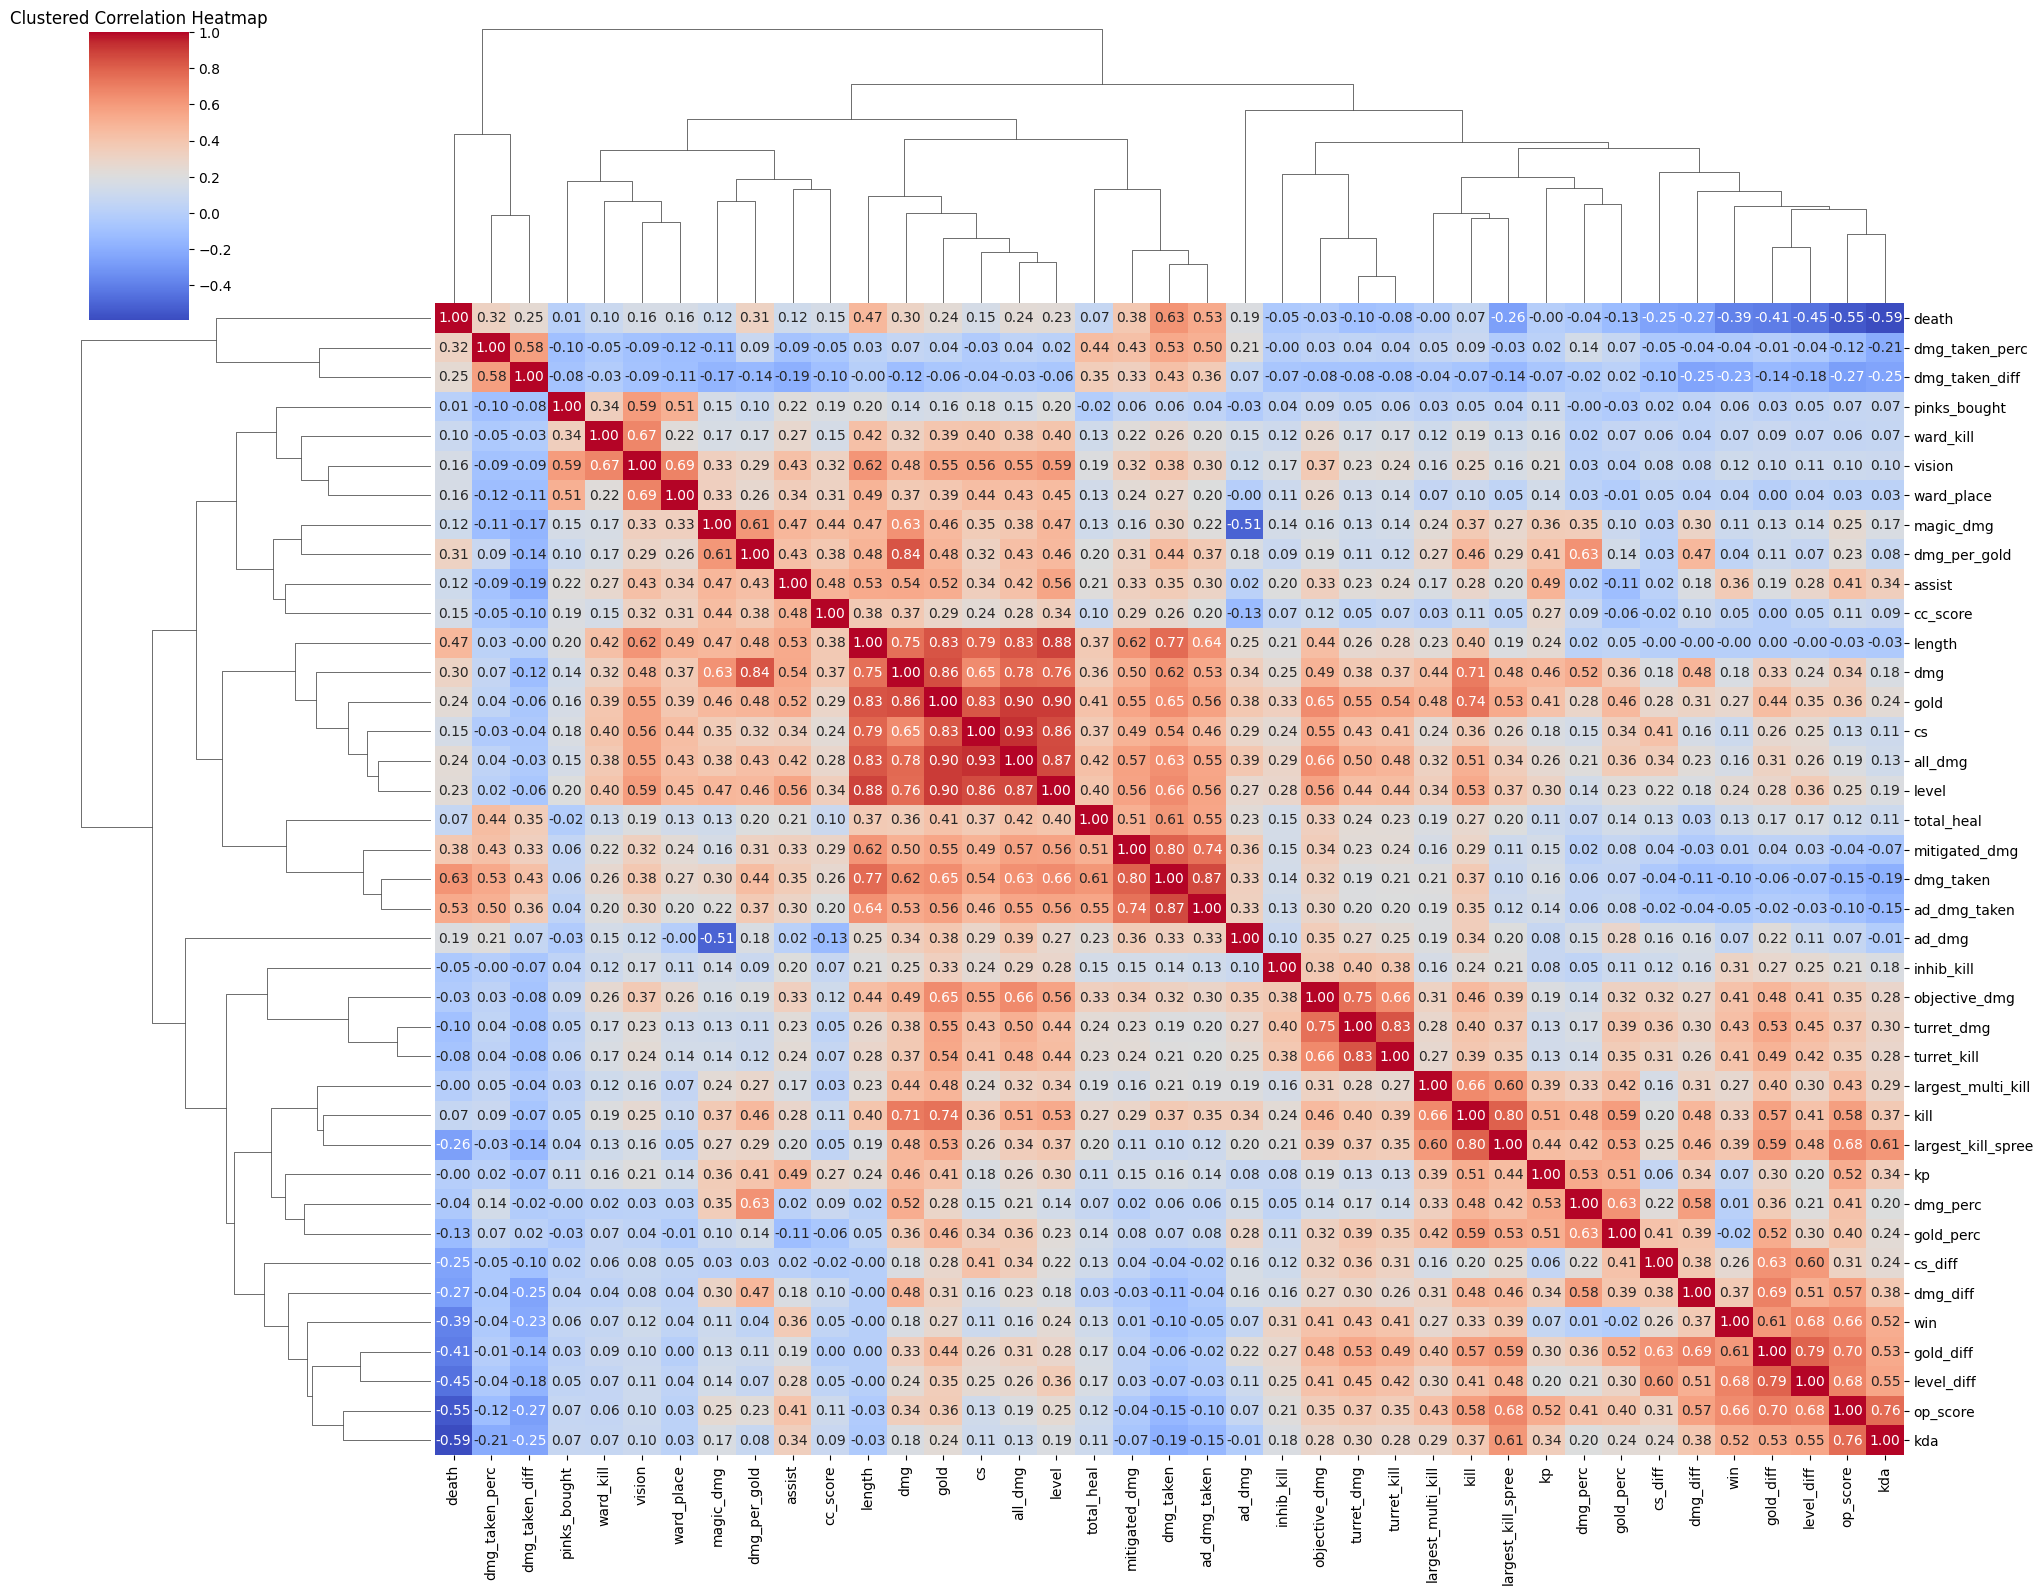

In [6]:
def plot_clustered_heatmap(data, title):
    sns.clustermap(data.corr(), figsize=(20, 16), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(title)
    plt.show()

plot_clustered_heatmap(data, 'Clustered Correlation Heatmap')

## Visualization of Feature Distributions

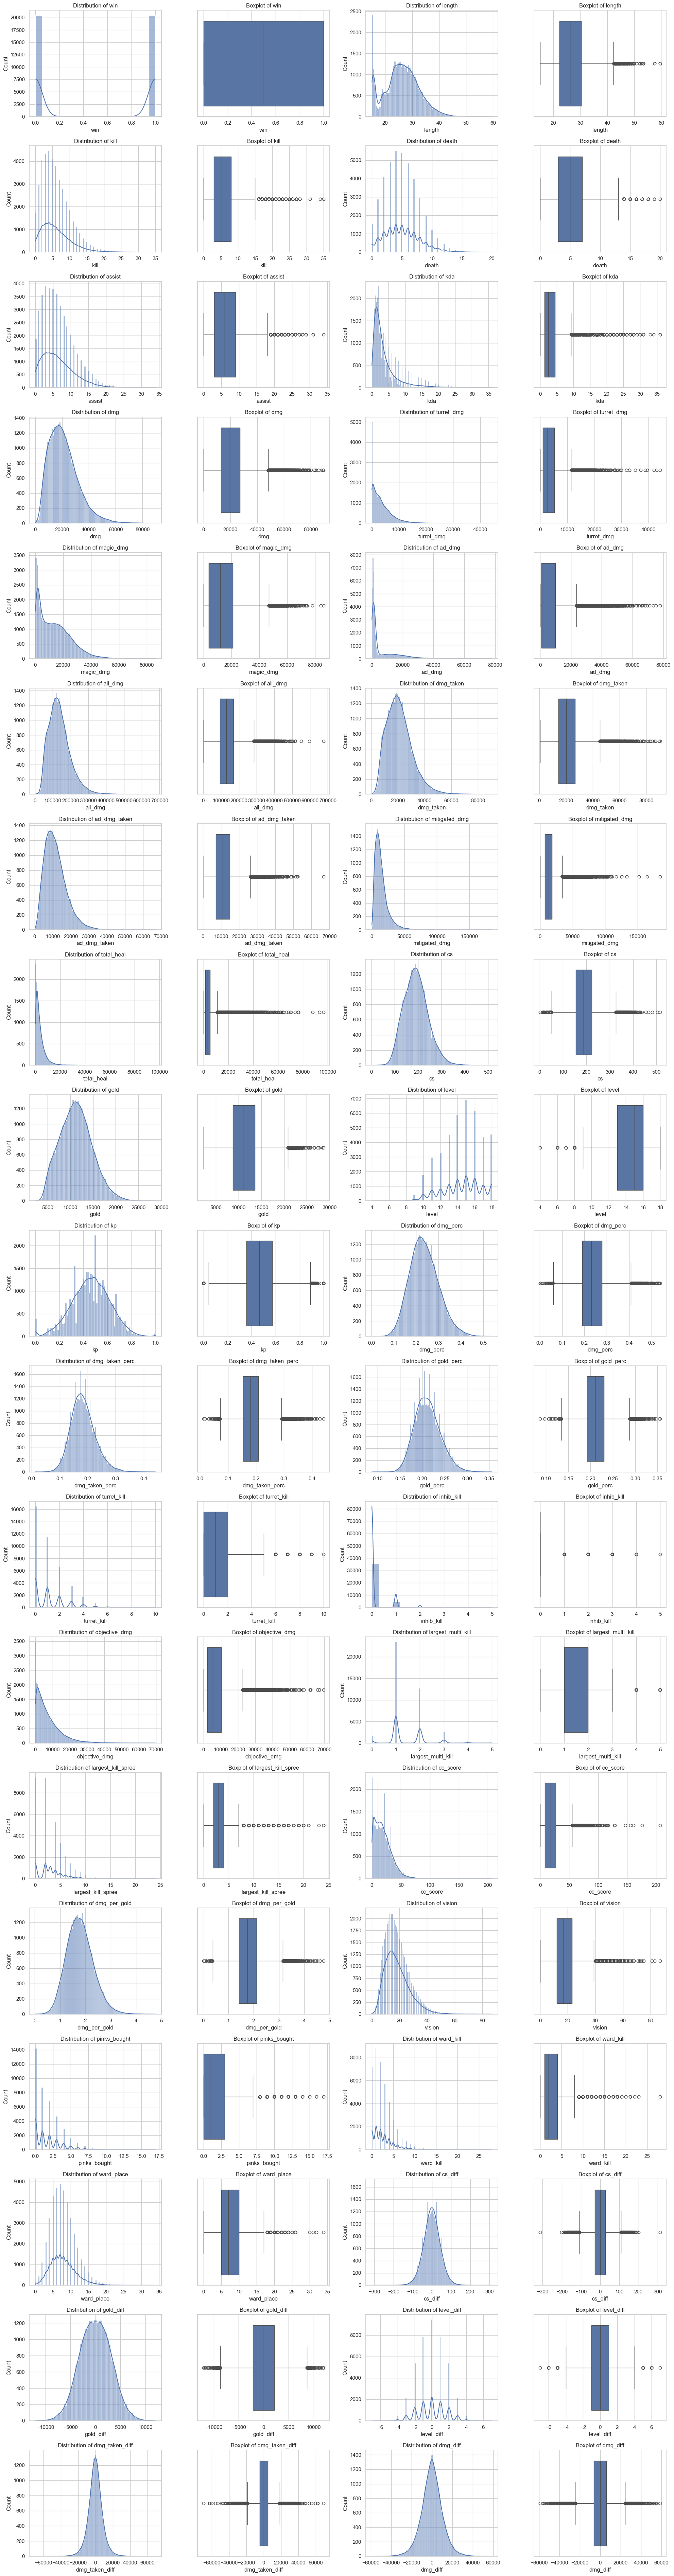

In [7]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Determining the number of rows needed for a 4-per-line layout (2 for histograms, 2 for box plots)
features_to_plot = data.columns.drop(['op_score'])  # Assuming we want to plot all features except the target variable
n_features = len(features_to_plot)
n_rows = (n_features + 1) // 2  # Adjusted for 4 plots per line

# Creating the figure with subplots
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 4 * n_rows))  # Adjusted width for 4 plots per line

for i, feature in enumerate(features_to_plot):
    row = i // 2
    col = (i % 2) * 2  # Adjust to place histograms and box plots side by side
    
    # Histogram
    sns.histplot(data[feature], kde=True, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
    
    # Box plot
    sns.boxplot(x=data[feature], ax=axes[row, col + 1])
    axes[row, col + 1].set_title(f'Boxplot of {feature}')

plt.tight_layout()


## Linear Regressions of Features with Respect to Game Length


Regression Analysis vs Game Length Summary

Feature: op_score
  Linear Regression: y = -0.01x + 5.46    R-squared: 0.00

Feature: win
  Linear Regression: y = 0.00x + 0.50    R-squared: 0.00

Feature: length
  Linear Regression: y = 1.00x + -0.00    R-squared: 1.00

Feature: kill
  Linear Regression: y = 0.26x + -0.98    R-squared: 0.16

Feature: death
  Linear Regression: y = 0.22x + -0.63    R-squared: 0.22

Feature: assist
  Linear Regression: y = 0.38x + -3.48    R-squared: 0.28

Feature: kda
  Linear Regression: y = -0.02x + 4.19    R-squared: 0.00

Feature: dmg
  Linear Regression: y = 1290.16x + -12666.89    R-squared: 0.56

Feature: turret_dmg
  Linear Regression: y = 145.19x + -163.74    R-squared: 0.07

Feature: magic_dmg
  Linear Regression: y = 852.60x + -8521.31    R-squared: 0.22

Feature: ad_dmg
  Linear Regression: y = 362.66x + -3075.76    R-squared: 0.06

Feature: all_dmg
  Linear Regression: y = 7974.53x + -71278.24    R-squared: 0.68

Feature: dmg_taken
  Linear Reg

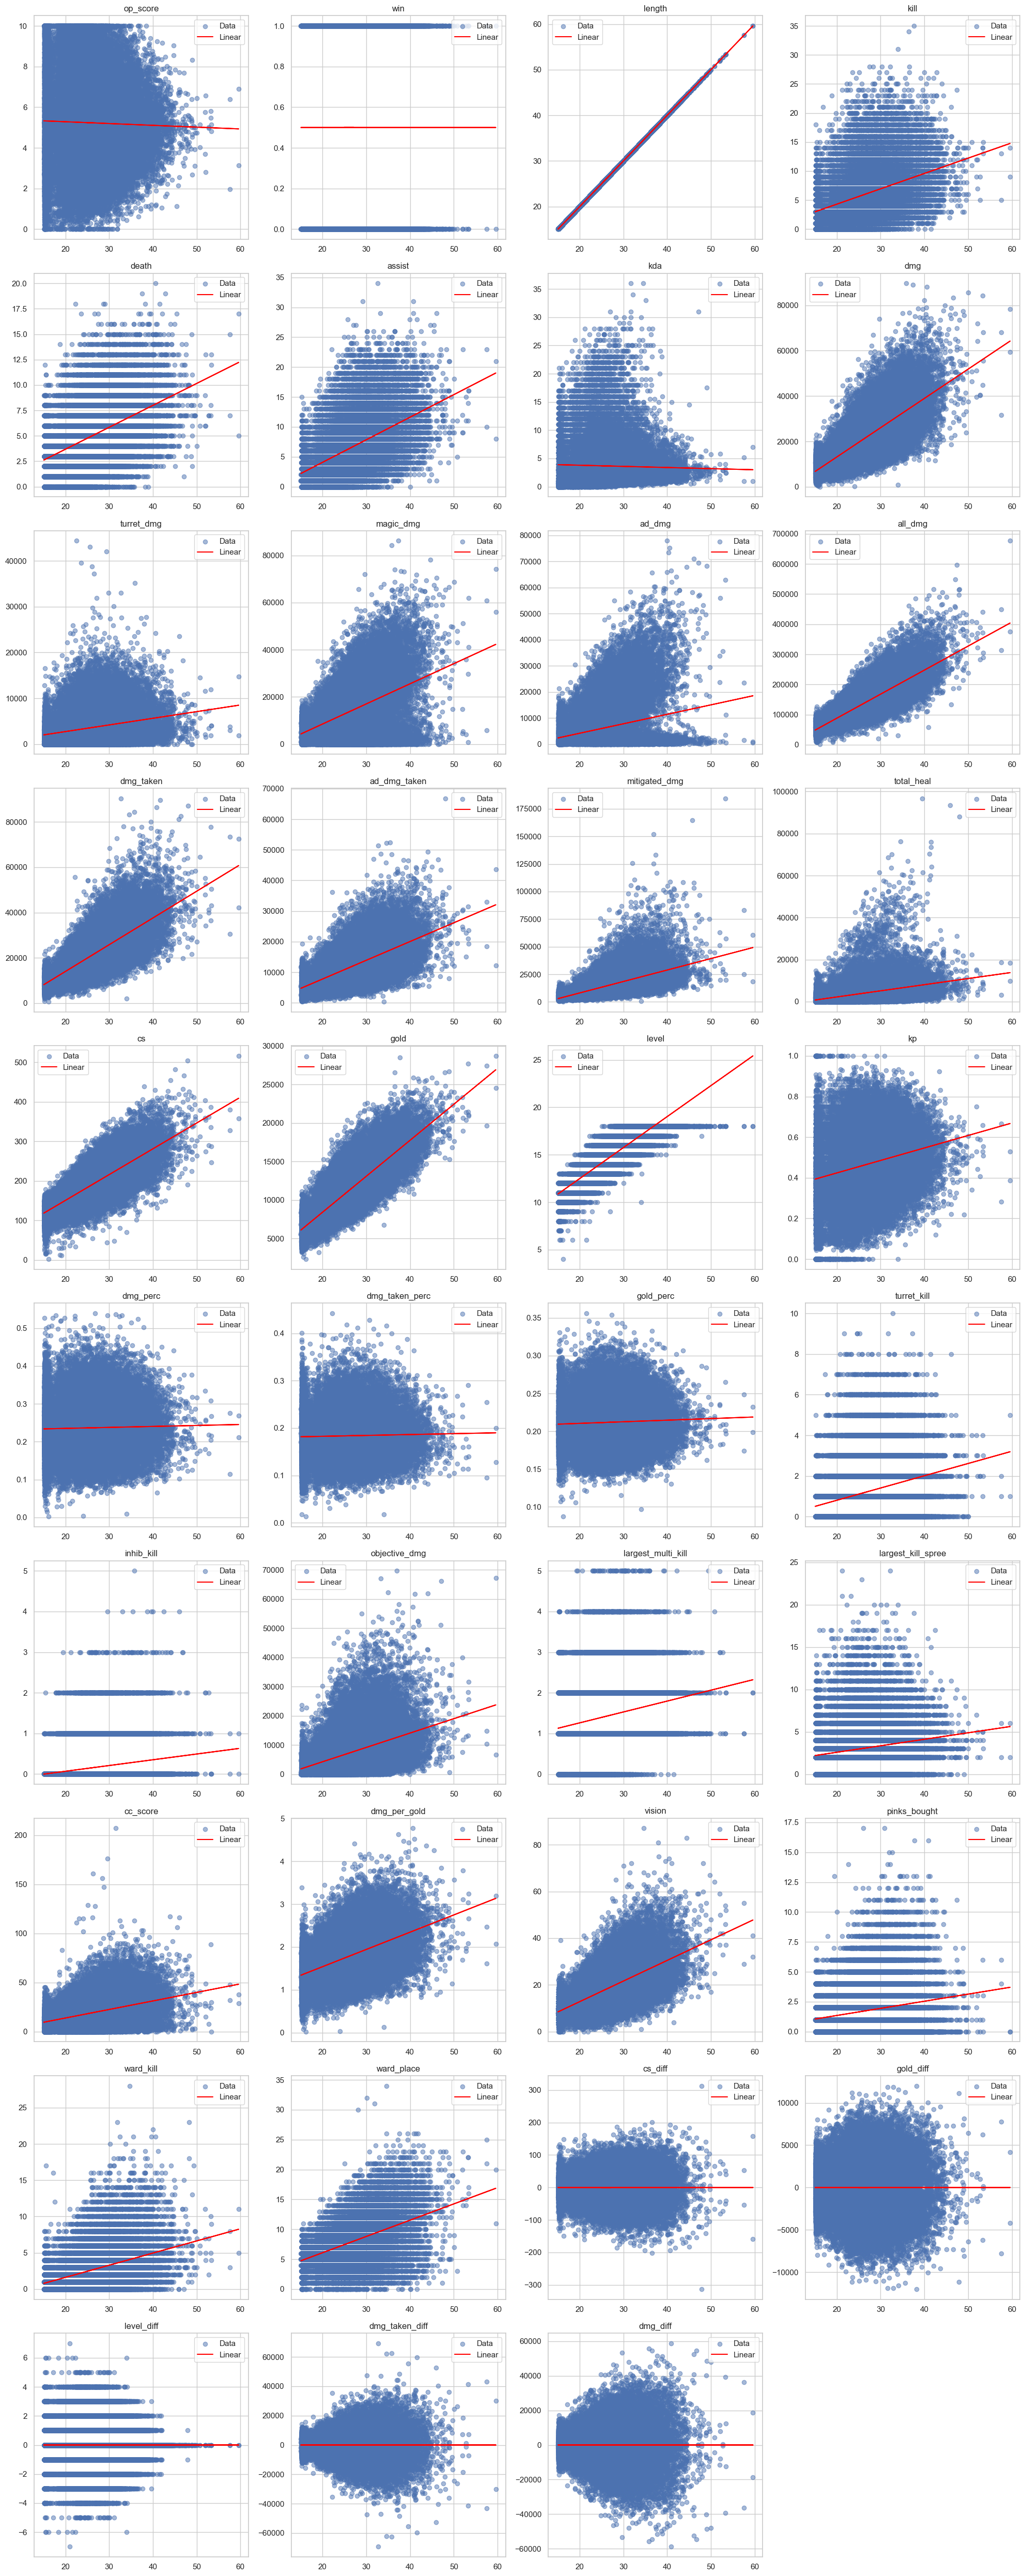

In [8]:
features_to_plot = data.columns

# Determine the layout for 4 plots per row
n_features = len(features_to_plot)
n_rows = n_features // 4 + (n_features % 4 > 0)  # Calculate rows needed for 4 columns

# Create subplots for a 4-column layout
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Initialize an empty list to store print statements
print_statements = []

for i, feature in enumerate(features_to_plot):
    # Data for plotting and analysis
    x = data['length']
    y = data[feature]
    
    # Linear regression
    lin_coeffs = np.polyfit(x, y, 1)
    lin_fit = np.polyval(lin_coeffs, x)
    lin_r2 = r2_score(y, lin_fit)
    
    # Prepare print statement
    print_statements.append(f"Feature: {feature}\n"
                            f"  Linear Regression: y = {lin_coeffs[0]:.2f}x + {lin_coeffs[1]:.2f}    R-squared: {lin_r2:.2f}\n")

    # Plotting on the current subplot
    ax = axes_flat[i]
    ax.scatter(x, y, label='Data', alpha=0.5)
    ax.plot(x, lin_fit, color='red', label='Linear')
    ax.set_title(feature)
    ax.legend()

# Hide any unused axes if the number of features is not a multiple of 4
for j in range(i + 1, n_rows * 4):
    axes_flat[j].axis('off')

plt.tight_layout()

# Display all print statements after plotting
print("Regression Analysis vs Game Length Summary\n")
for statement in print_statements:
    print(statement)


## Linear Regressions of Features with Respect to OP Score

Regression Analysis vs OP Score Summary

Feature: op_score
  Linear Regression: y = 1.00x + -0.00    R-squared: 1.00

Feature: win
  Linear Regression: y = 0.16x + -0.32    R-squared: 0.43

Feature: length
  Linear Regression: y = -0.08x + 26.58    R-squared: 0.00

Feature: kill
  Linear Regression: y = 1.14x + -0.01    R-squared: 0.34

Feature: death
  Linear Regression: y = -0.75x + 8.93    R-squared: 0.30

Feature: assist
  Linear Regression: y = 0.86x + 1.89    R-squared: 0.17

Feature: kda
  Linear Regression: y = 1.37x + -3.47    R-squared: 0.57

Feature: dmg
  Linear Regression: y = 1733.91x + 12024.72    R-squared: 0.11

Feature: turret_dmg
  Linear Regression: y = 622.16x + 381.79    R-squared: 0.14

Feature: magic_dmg
  Linear Regression: y = 1369.29x + 6627.60    R-squared: 0.06

Feature: ad_dmg
  Linear Regression: y = 294.72x + 4872.44    R-squared: 0.00

Feature: all_dmg
  Linear Regression: y = 5363.04x + 109340.51    R-squared: 0.03

Feature: dmg_taken
  Linear Regressi

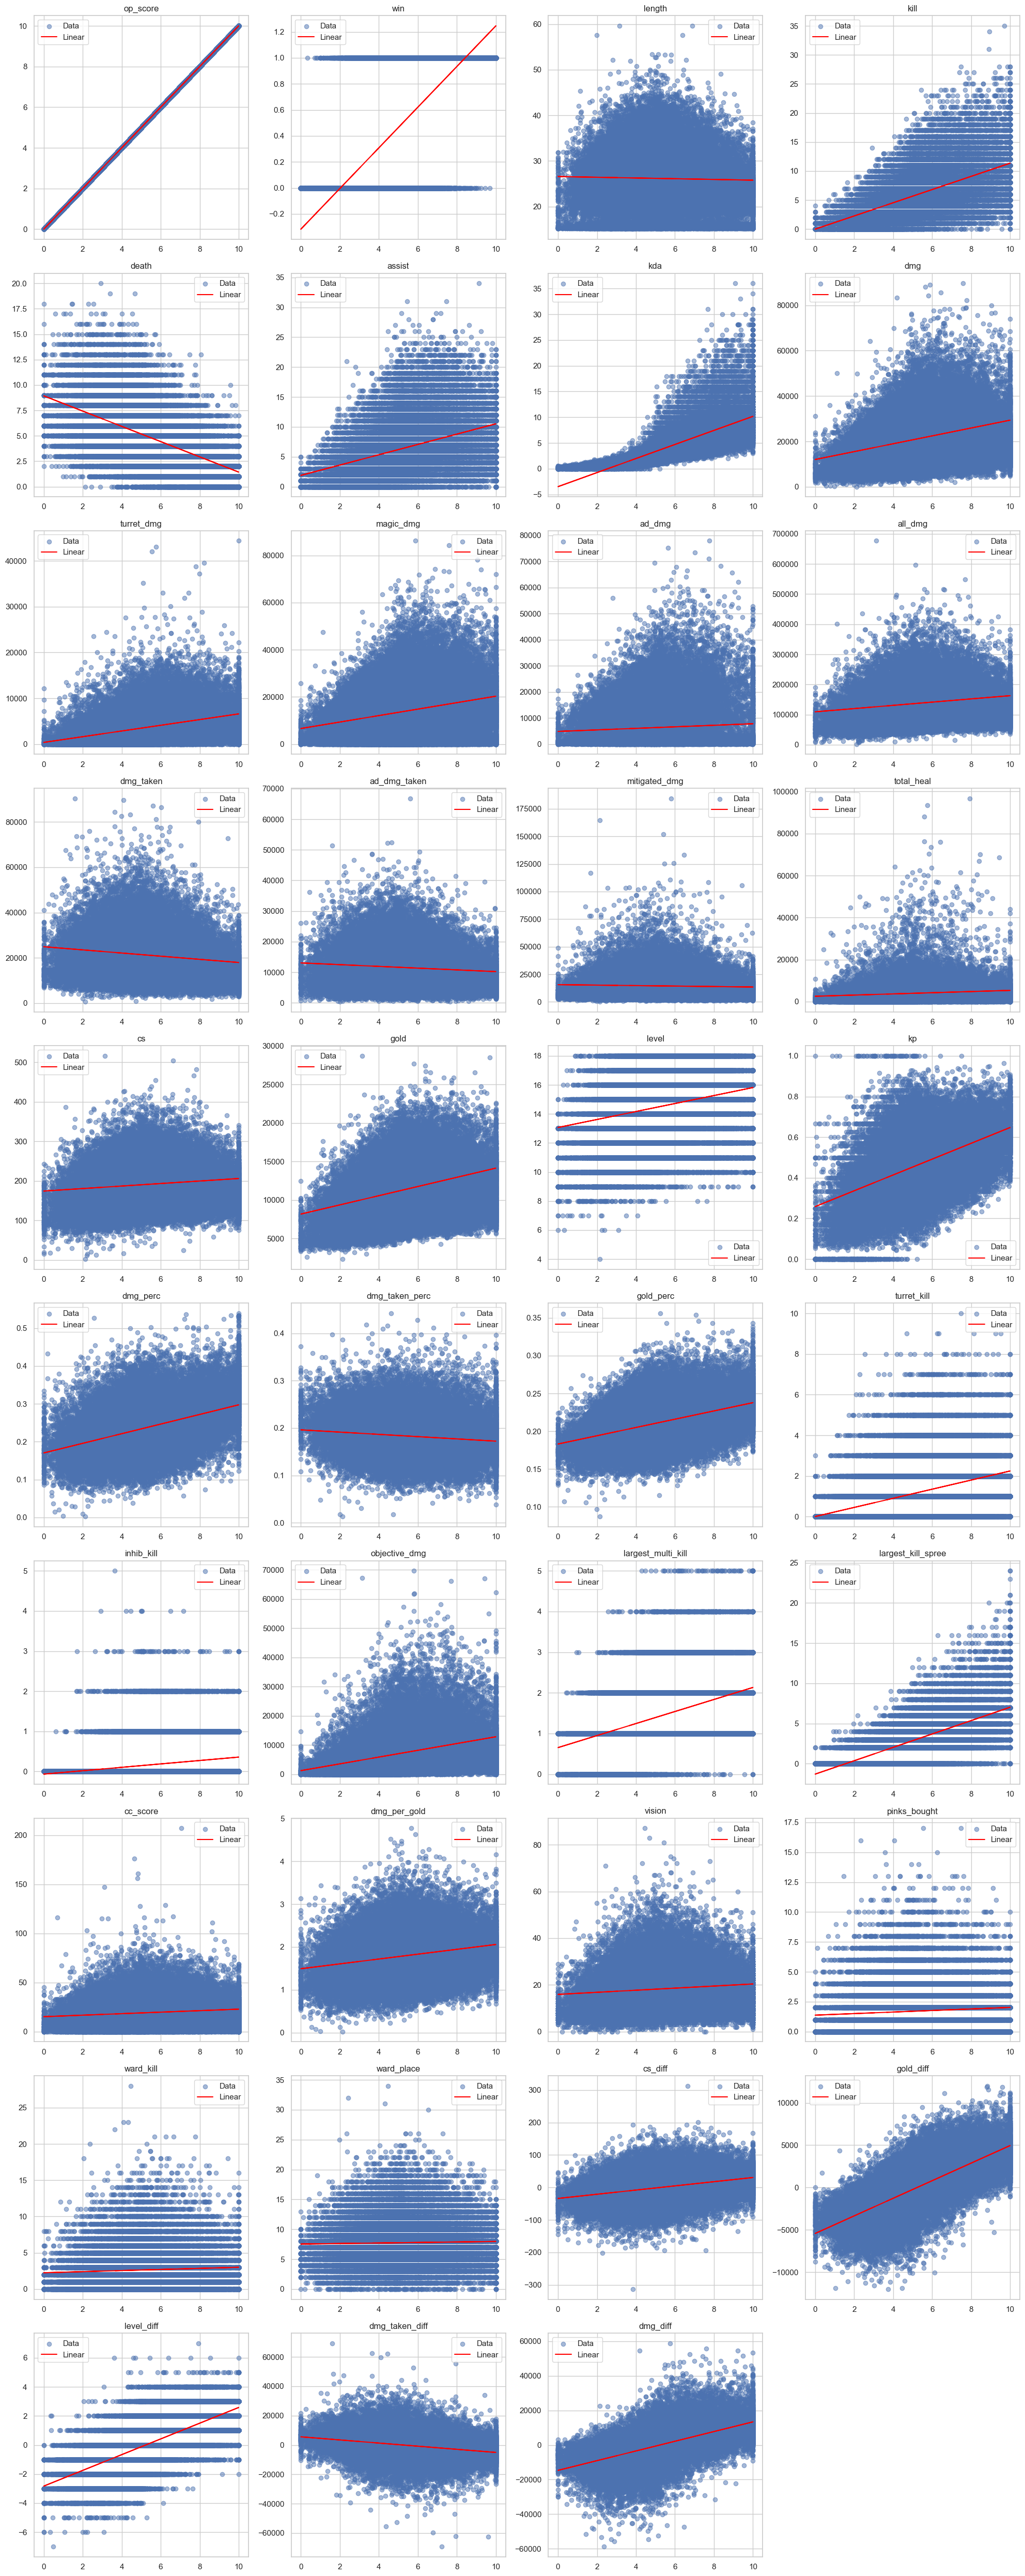

In [9]:
features_to_plot = data.columns

# Determine the layout for 4 plots per row
n_features = len(features_to_plot)
n_rows = n_features // 4 + (n_features % 4 > 0)  # Calculate rows needed for 4 columns

# Create subplots for a 4-column layout
fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5 * n_rows))

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# Initialize an empty list to store print statements
print_statements = []

for i, feature in enumerate(features_to_plot):
    # Data for plotting and analysis
    x = data['op_score']
    y = data[feature]
    
    # Linear regression
    lin_coeffs = np.polyfit(x, y, 1)
    lin_fit = np.polyval(lin_coeffs, x)
    lin_r2 = r2_score(y, lin_fit)
    
    # Prepare print statement
    print_statements.append(f"Feature: {feature}\n"
                            f"  Linear Regression: y = {lin_coeffs[0]:.2f}x + {lin_coeffs[1]:.2f}    R-squared: {lin_r2:.2f}\n")

    # Plotting on the current subplot
    ax = axes_flat[i]
    ax.scatter(x, y, label='Data', alpha=0.5)
    ax.plot(x, lin_fit, color='red', label='Linear')
    ax.set_title(feature)
    ax.legend()

# Hide any unused axes if the number of features is not a multiple of 4
for j in range(i + 1, n_rows * 4):
    axes_flat[j].axis('off')

plt.tight_layout()

# Display all print statements after plotting
print("Regression Analysis vs OP Score Summary\n")
for statement in print_statements:
    print(statement)


## Calculating and Visualizing Variance Inflation Factor (VIF)

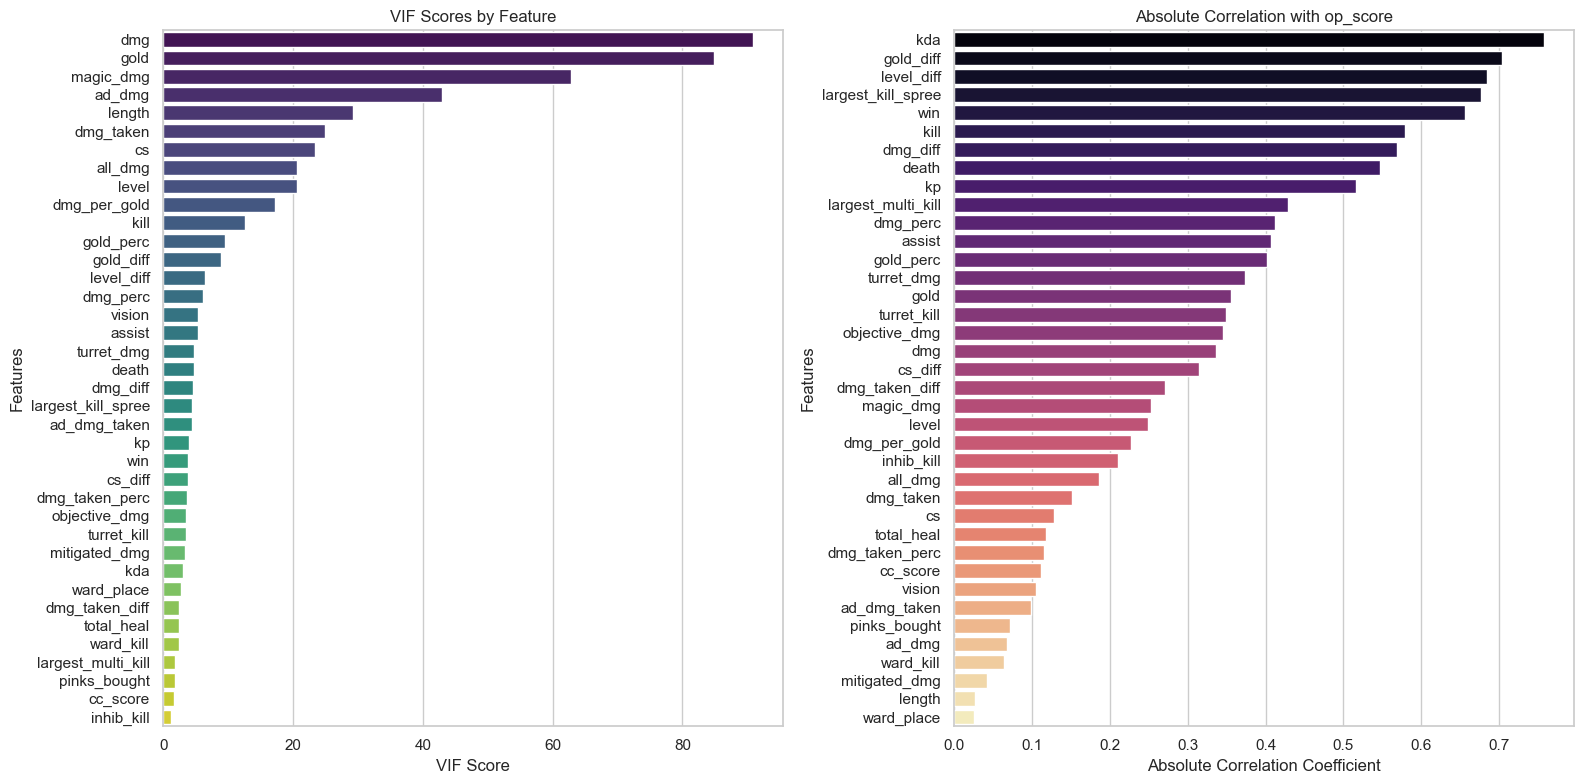

In [10]:
X = data.drop(['op_score'], axis=1) 
X_const = add_constant(X)

# Calculate VIF and sort
vif = pd.DataFrame()
vif['Feature'] = X_const.columns[1:]  # Exclude the constant from the features
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(1, X_const.shape[1])]  # Start from index 1 to exclude 'const'
vif_sorted = vif.sort_values('VIF', ascending=False)

# Calculate and sort absolute correlation with 'op_score'
correlation_with_op_score = data.drop(['op_score'], axis=1).apply(lambda x: x.corr(data['op_score'])).abs().sort_values(ascending=False)

# Visualizing both VIF and Correlation with op_score using horizontal bars, suppressing warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))

    # Horizontal VIF Plot
    sns.barplot(x='VIF', y='Feature', data=vif_sorted, ax=ax[0], palette=sns.color_palette("viridis", len(vif_sorted)))
    ax[0].set_title('VIF Scores by Feature')
    ax[0].set_xlabel('VIF Score')
    ax[0].set_ylabel('Features')

    # Horizontal Correlation Plot
    sns.barplot(x=correlation_with_op_score.values, y=correlation_with_op_score.index, ax=ax[1], palette=sns.color_palette("magma", len(correlation_with_op_score)))
    ax[1].set_title('Absolute Correlation with op_score')
    ax[1].set_xlabel('Absolute Correlation Coefficient')
    ax[1].set_ylabel('Features')

plt.tight_layout()
plt.show()